In this workbook, I have built classfication model using several algorithm DT, RF, xgboost to predict whether a client will default on his.her credit card payment

The prediction is done using some demographic features about the client and payment history 

In [ ]:
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


In [ ]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
credit_data = pd.read_excel("MMA867 A3 -- credit data.xlsx")
credit_data.drop(columns='ID', inplace=True)

In [ ]:
credit_data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_0'],
      dtype='object')

**Missing Data** 

In [ ]:
credit_data.isnull().values.any() ## There is no missing value

False

**Target Variable distribution**

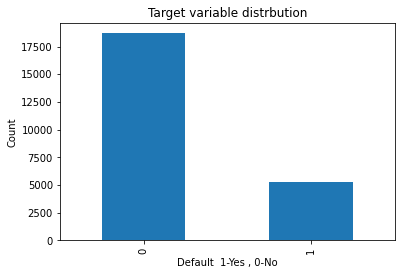

In [ ]:
count = credit_data.default_0.value_counts()
count.plot.bar()
plt.title("Target variable distrbution")
plt.ylabel("Count")
plt.xlabel("Default  1-Yes , 0-No")
plt.show()

**Correlation Matrix**

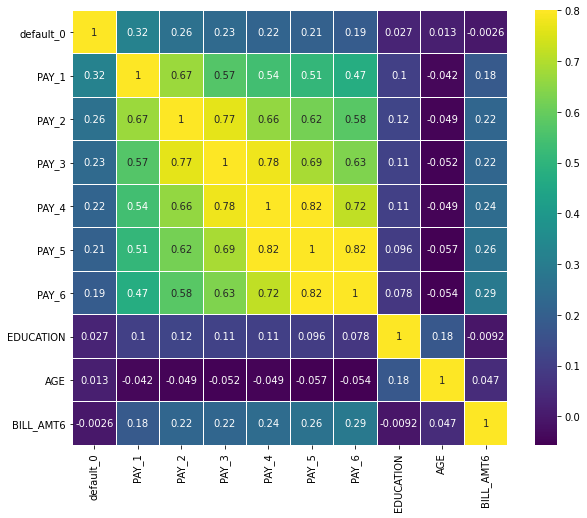

In [ ]:
# Correlation matrix of top 10 most correlated variables
correlation = credit_data.select_dtypes(include=np.number).corr()
cor_target = correlation['default_0']
## Heatmap of feature with High correlations
plt.figure(figsize=(10,8))
k = 10
top_10_Corr = correlation.nlargest(k, 'default_0')['default_0'].index
cm = np.corrcoef(credit_data[top_10_Corr].to_numpy().T)
sns.heatmap(cm, vmax=0.8, linewidths=0.01, square=True, annot=True, cmap='viridis', linecolor="white", \
            xticklabels=top_10_Corr.values, yticklabels=top_10_Corr.values)
plt.show()

**Scatter plot of high correlated columns**

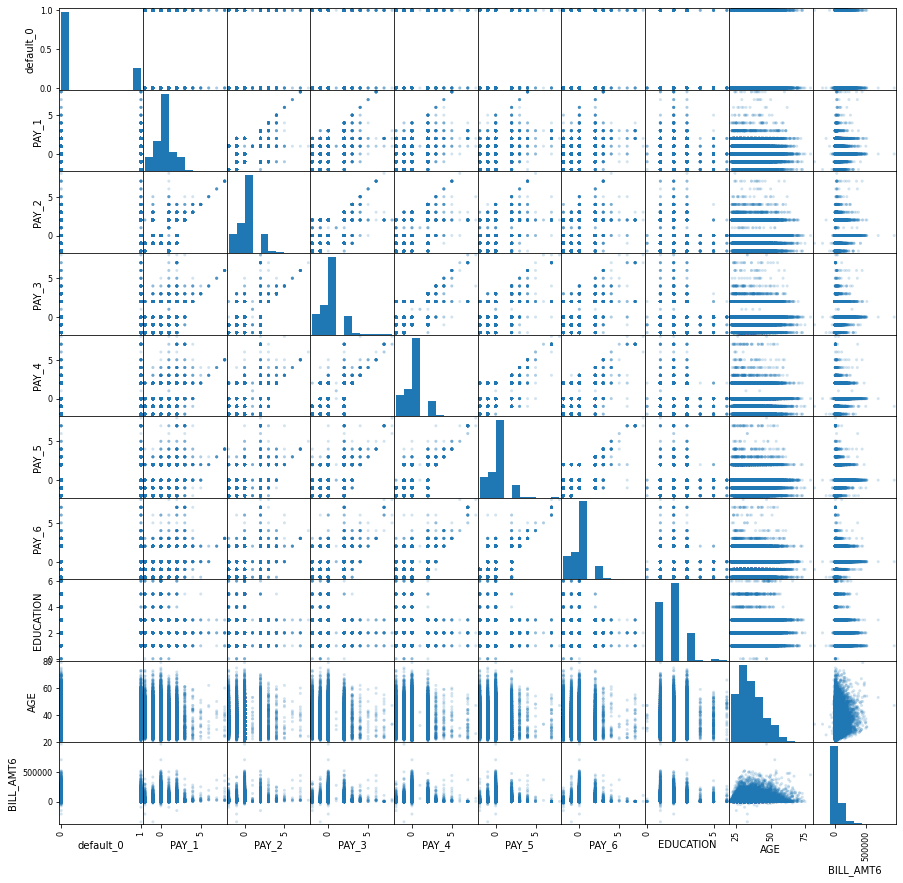

In [ ]:
pd.plotting.scatter_matrix(credit_data[top_10_Corr], alpha=0.2, figsize=(15, 15))
plt.show()

In [ ]:
X = credit_data.iloc[:,:-1]
Y = credit_data.iloc[:,-1]

**Standardize Data**

In [ ]:
from sklearn.preprocessing import StandardScaler
st = StandardScaler()
scaled_X = st.fit_transform(X)

**Data Splitup**

In [ ]:
## split the data in training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y,test_size=0.1, stratify=Y)

print(f"Shape of X train {X_train.shape}")
print(f"Shape of X test {X_test.shape}")
print(f"Shape of y train {y_train.shape}")
print(f"Shape of y test {y_test.shape}")

Shape of X train (21600, 23)
Shape of X test (2400, 23)
Shape of y train (21600,)
Shape of y test (2400,)


# Model Training

In [ ]:
# First we define a set of functions to compute the metrics of the model

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

**1. Decision Tree**

In [ ]:
import time
start_time = time.time()
score_func = make_scorer(roc_auc_score, greater_is_better=True)
depths = np.arange(1, 21)
n_leafs = np.arange(0,120,20)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
f1_score = make_scorer(f1_score, greater_is_better=True)

# Parameter tuning
param_grid = [{'max_depth':depths,
              'min_samples_leaf':n_leafs}]
cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
gsearch = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1,min_samples_split=2), param_grid=param_grid,n_jobs=-1, scoring=score_func, cv=cv)

gs_result = gsearch.fit(X_train, y_train)
print(f"Decision Tree - Best score {gs_result.best_score_}")
print(f"\nDecision Tree - Best Model {gs_result.best_params_})")

print("--- %s seconds ---" % (time.time() - start_time))

Decision Tree - Best F1 score 0.6605274499583798

Decision Tree - Best Model {'max_depth': 3, 'min_samples_leaf': 20})
--- 78.51729607582092 seconds ---


Metrics of the Decision Tree model: 

Confusion matrix: 
[[1847  457]
 [  22   74]]
                                   Accuracy: 0.8004166666666667
                   SENSITIVITY (aka RECALL): 0.1393596986817326
                 SPECIFICITY (aka FALL-OUT): 0.9882289994649546
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.7708333333333334
                 NEGATIVE PREDICTIVE VALUE): 0.8016493055555556


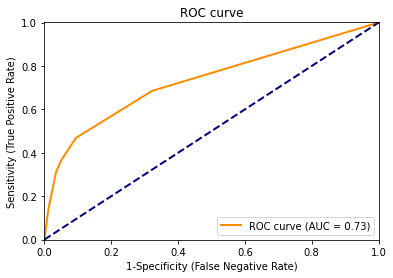

 AUC: 0.7321961349765578


In [ ]:
# Predict on Test set using grid search result
class_threshold = 0.7
y_pred_prob = gs_result.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) 

print('Metrics of the Decision Tree model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [ ]:
## Tuning the Class threshold value
class_threshold = np.arange(0.5,0.8,0.01)
f1score = []
for thres in class_threshold:
  y_pred = np.where(y_pred_prob > thres, 1, 0)
  f1score.append((f1_score(y_test, y_pred)))
print(pd.DataFrame(f1score, columns=['F1 Score'], index=class_threshold))

      F1 Score
0.50  0.471166
0.51  0.471166
0.52  0.471166
0.53  0.471166
0.54  0.433640
0.55  0.433640
0.56  0.433640
0.57  0.433640
0.58  0.433640
0.59  0.433640
0.60  0.433640
0.61  0.433640
0.62  0.433640
0.63  0.433640
0.64  0.433640
0.65  0.433640
0.66  0.433640
0.67  0.433640
0.68  0.236045
0.69  0.236045
0.70  0.236045
0.71  0.236045
0.72  0.236045
0.73  0.236045
0.74  0.236045
0.75  0.236045
0.76  0.236045
0.77  0.236045
0.78  0.236045
0.79  0.000000
0.80  0.000000


____________________________________________________________________

**2. Random Forest**

In [ ]:
import time
start_time = time.time()

score_func = make_scorer(roc_auc_score, greater_is_better=True)
from sklearn.ensemble import RandomForestClassifier
n_estimators = [10, 100, 200,300,400,500,600]
grid = dict(n_estimators=n_estimators)
cv = StratifiedKFold(n_splits=10, shuffle=True,random_state=1)
gsearch = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid=grid,n_jobs=-1, scoring=score_func, cv=cv)

gs_result = gsearch.fit(X_train, y_train)
print(f"Random Forest - Best score {gs_result.best_score_}")
print(f"\nRandom Forest - Best Model {gs_result.best_params_})")

print("--- %s seconds ---" % (time.time() - start_time))

Random Forest - Best score 0.6565338041269786

Random Forest - Best Model {'n_estimators': 400})
--- 918.2874920368195 seconds ---


Confusion matrix: 
[[1763  332]
 [ 106  199]]
                                   Accuracy: 0.8175
                   SENSITIVITY (aka RECALL): 0.3747645951035782
                 SPECIFICITY (aka FALL-OUT): 0.9432851792402355
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.6524590163934426
                 NEGATIVE PREDICTIVE VALUE): 0.841527446300716


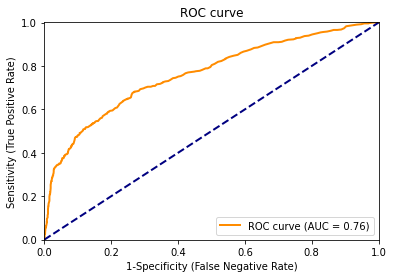

 AUC: 0.7629229605043736


In [ ]:
## Predict on the test set and calculate the metrics 
class_threshold = 0.5
y_pred_prob = gs_result.predict_proba(X_test)[:,1] # probabilities  
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

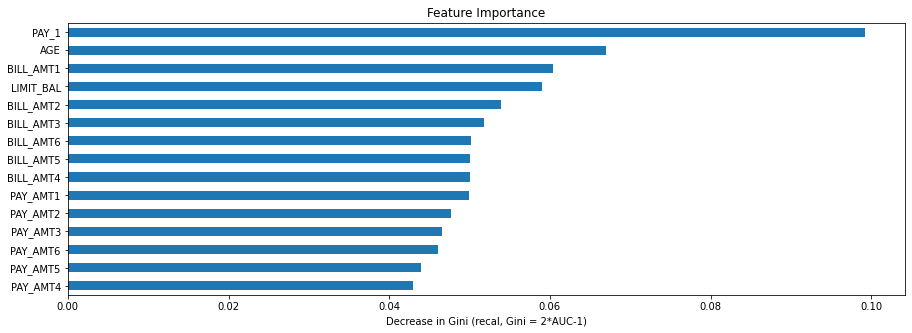

In [ ]:
# calculate feature importances
importances = gs_result.best_estimator_.feature_importances_

# plot them
plt.figure(figsize=(15,5))
plt.title('Feature Importance')
plt.xlabel('Decrease in Gini (recal, Gini = 2*AUC-1)')
feature_importances = pd.Series(gs_result.best_estimator_.feature_importances_, index=X.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')

________________________________________________________________________________________

**3. XGBoost**

In [ ]:
import time
start_time = time.time()

score_func = make_scorer(roc_auc_score, greater_is_better=True)
from xgboost import XGBClassifier
alpha = [0.05, 0.20, 0.30]
maxdepth = [3,6,9,12]
minchildweight = [3,5,7]
gamma = [0.0,0.1,0.2,0.3]
samplebytree = [0.3,0.5,0.7]

grid = dict(learning_rate=alpha,max_depth=maxdepth,min_child_weight=minchildweight,gamma=gamma,\
            colsample_bytree=samplebytree)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
gsearch = GridSearchCV(estimator=XGBClassifier(random_state=1, nthread=-1), param_grid=grid,n_jobs=-1, scoring=score_func, cv=cv)
gs_result = gsearch.fit(X_train, y_train)
print(f"XGBoost  - Best  score {gs_result.best_score_}")
print(f"\nXGBoost - Best Model {gs_result.best_params_})")

print("--- %s seconds ---" % (time.time() - start_time))

XGBoost  - Best  score 0.6594165376566596

XGBoost - Best Model {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 7})
--- 5249.448783874512 seconds ---


Run2 - Retune the paramater by trying more values closer to the best parameters optimazid 
- 'colsample_bytree': 0.7 
-'gamma': 0.2
- 'learning_rate': 0.2 
- 'max_depth': 6 
- 'min_child_weight': 7

In [ ]:
samplebytree = [0.7, 0.75, 0.8]
gamma = [0.2]
alpha = [0.15, 0.2, 0.25]
maxdepth = [5,6,7]
minchildweight = [7,8]

grid = dict(learning_rate=alpha,max_depth=maxdepth,min_child_weight=minchildweight,gamma=gamma,\
            colsample_bytree=samplebytree)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
gsearch = GridSearchCV(estimator=XGBClassifier(random_state=1, nthread=-1), param_grid=grid,n_jobs=-1, scoring=score_func, cv=cv)
gs_result = gsearch.fit(X_train, y_train)
print(f"XGBoost  - Best  score (Run2) {gs_result.best_score_}")
print(f"\nXGBoost - Best Model (Run2) {gs_result.best_params_})")

print("--- %s seconds ---" % (time.time() - start_time))


XGBoost  - Best  score (Run2) 0.660803310954311

XGBoost - Best Model (Run2) {'colsample_bytree': 0.75, 'gamma': 0.2, 'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 7})
--- 8273.000849485397 seconds ---


Run 3 - Retune the paramater by trying more values closer to the best parameters optimazid

'colsample_bytree': 0.75
'gamma': 0.2
'learning_rate': 0.15
'max_depth': 6
'min_child_weight': 7

In [ ]:
samplebytree = [0.75]
gamma = [0.15,0.2,0.25]
alpha = [0.10,0.12,0.15,0.17]
maxdepth = [6]
minchildweight = [7]

grid = dict(learning_rate=alpha,max_depth=maxdepth,min_child_weight=minchildweight,gamma=gamma,\
            colsample_bytree=samplebytree)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
gsearch = GridSearchCV(estimator=XGBClassifier(random_state=1, nthread=-1), param_grid=grid,n_jobs=-1, scoring=score_func, cv=cv)
gs_result = gsearch.fit(X_train, y_train)
print(f"XGBoost  - Best  score (Run2) {gs_result.best_score_}")
print(f"\nXGBoost - Best Model (Run2) {gs_result.best_params_})")

print("--- %s seconds ---" % (time.time() - start_time))


XGBoost  - Best  score (Run2) 0.660803310954311

XGBoost - Best Model (Run2) {'colsample_bytree': 0.75, 'gamma': 0.2, 'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 7})
--- 8617.853394031525 seconds ---
